In [1]:
pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 66.1 MB/s eta 0:00:00


In [2]:
!pip install scikit-learn --upgrade

In [3]:
import torch
import timm
import faiss
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [10]:
# Load RegNetX-032 model
model = timm.create_model("regnetx_032", pretrained=True, num_classes=0, features_only=True)
model.eval().to(device)

model.safetensors:   0%|          | 0.00/61.5M [00:00<?, ?B/s]

FeatureListNet(
  (stem): ConvNormAct(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): ReLU(inplace=True)
    )
  )
  (s1): RegStage(
    (b1): Bottleneck(
      (conv1): ConvNormAct(
        (conv): Conv2d(32, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNormAct2d(
          96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): ReLU(inplace=True)
        )
      )
      (conv2): ConvNormAct(
        (conv): Conv2d(96, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=2, bias=False)
        (bn): BatchNormAct2d(
          96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): ReLU(inplace=True)
        )
      )
      (se): Identity()
      (conv3): ConvNormAc

In [11]:
# Define feature extractor using last stage
def extract_features(x):
    with torch.no_grad():
        feats = model(x)[-1]  # Get last feature map
        pooled = torch.nn.functional.adaptive_avg_pool2d(feats, 1).squeeze(-1).squeeze(-1)
    return pooled

In [12]:
# Transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [13]:
# Load CIFAR-100
def load_cifar100():
    dataset = datasets.CIFAR100(root="./data", train=True, download=True, transform=transform)
    dataloader = DataLoader(dataset, batch_size=128, shuffle=False, num_workers=2)
    return dataset, dataloader

In [14]:
# Get embeddings
def get_embeddings(dataloader):
    all_features = []
    with torch.no_grad():
        for images, _ in dataloader:
            images = images.to(device)
            feats = extract_features(images)
            all_features.append(feats.cpu().numpy())
    return np.vstack(all_features)

In [15]:
# FAISS index
def build_faiss_index(embeddings):
    index = faiss.IndexFlatL2(embeddings.shape[1])
    index.add(embeddings)
    return index

In [16]:
# FAISS search
def faiss_search(index, query_embedding, k=50):
    _, indices = index.search(query_embedding, k)
    return indices[0]

In [17]:
# Metrics
def compute_metrics(retrieved_indices, query_labels, database_labels, k=50):
    tp, fp = 0, 0
    for i in range(len(query_labels)):
        retrieved_labels = database_labels[retrieved_indices[i]]
        relevant_label = query_labels[i]
        tp += np.sum(retrieved_labels == relevant_label)
        fp += k - np.sum(retrieved_labels == relevant_label)
    total = len(query_labels) * k
    return tp / total, fp / total

In [19]:
# Show results
def show_results(query_img, faiss_idxs, original_dataset, query_label=None, faiss_precision=None, faiss_fpr=None):
    fig = plt.figure(figsize=(20, 12))
    ax = plt.subplot(6, 10, 1)
    ax.imshow(query_img.permute(1, 2, 0))
    ax.set_title(f"Query\n(Class: {label_names[query_label]})" if query_label else "Query\n(Class: Unknown)")
    ax.axis("off")

    for i, idx in enumerate(faiss_idxs[:50]):
        img, label = original_dataset[idx]
        ax = plt.subplot(6, 10, i + 2)
        ax.imshow(img.permute(1, 2, 0).clamp(0, 1))
        ax.set_title(f"FAISS {i+1}\n{label_names[label]}", fontsize=8)
        ax.axis("off")

    if faiss_precision is not None:
        fig.suptitle(f"FAISS Precision: {faiss_precision:.3f} | FPR: {faiss_fpr:.3f}", fontsize=16)

    plt.tight_layout()
    plt.show()

100%|██████████| 169M/169M [00:04<00:00, 34.5MB/s]



Query 1 (Index: 300, Label: plain):
Top-10: Precision = 0.300, FPR = 0.700
Top-20: Precision = 0.300, FPR = 0.700
Top-30: Precision = 0.300, FPR = 0.700
Top-40: Precision = 0.300, FPR = 0.700
Top-50: Precision = 0.260, FPR = 0.740


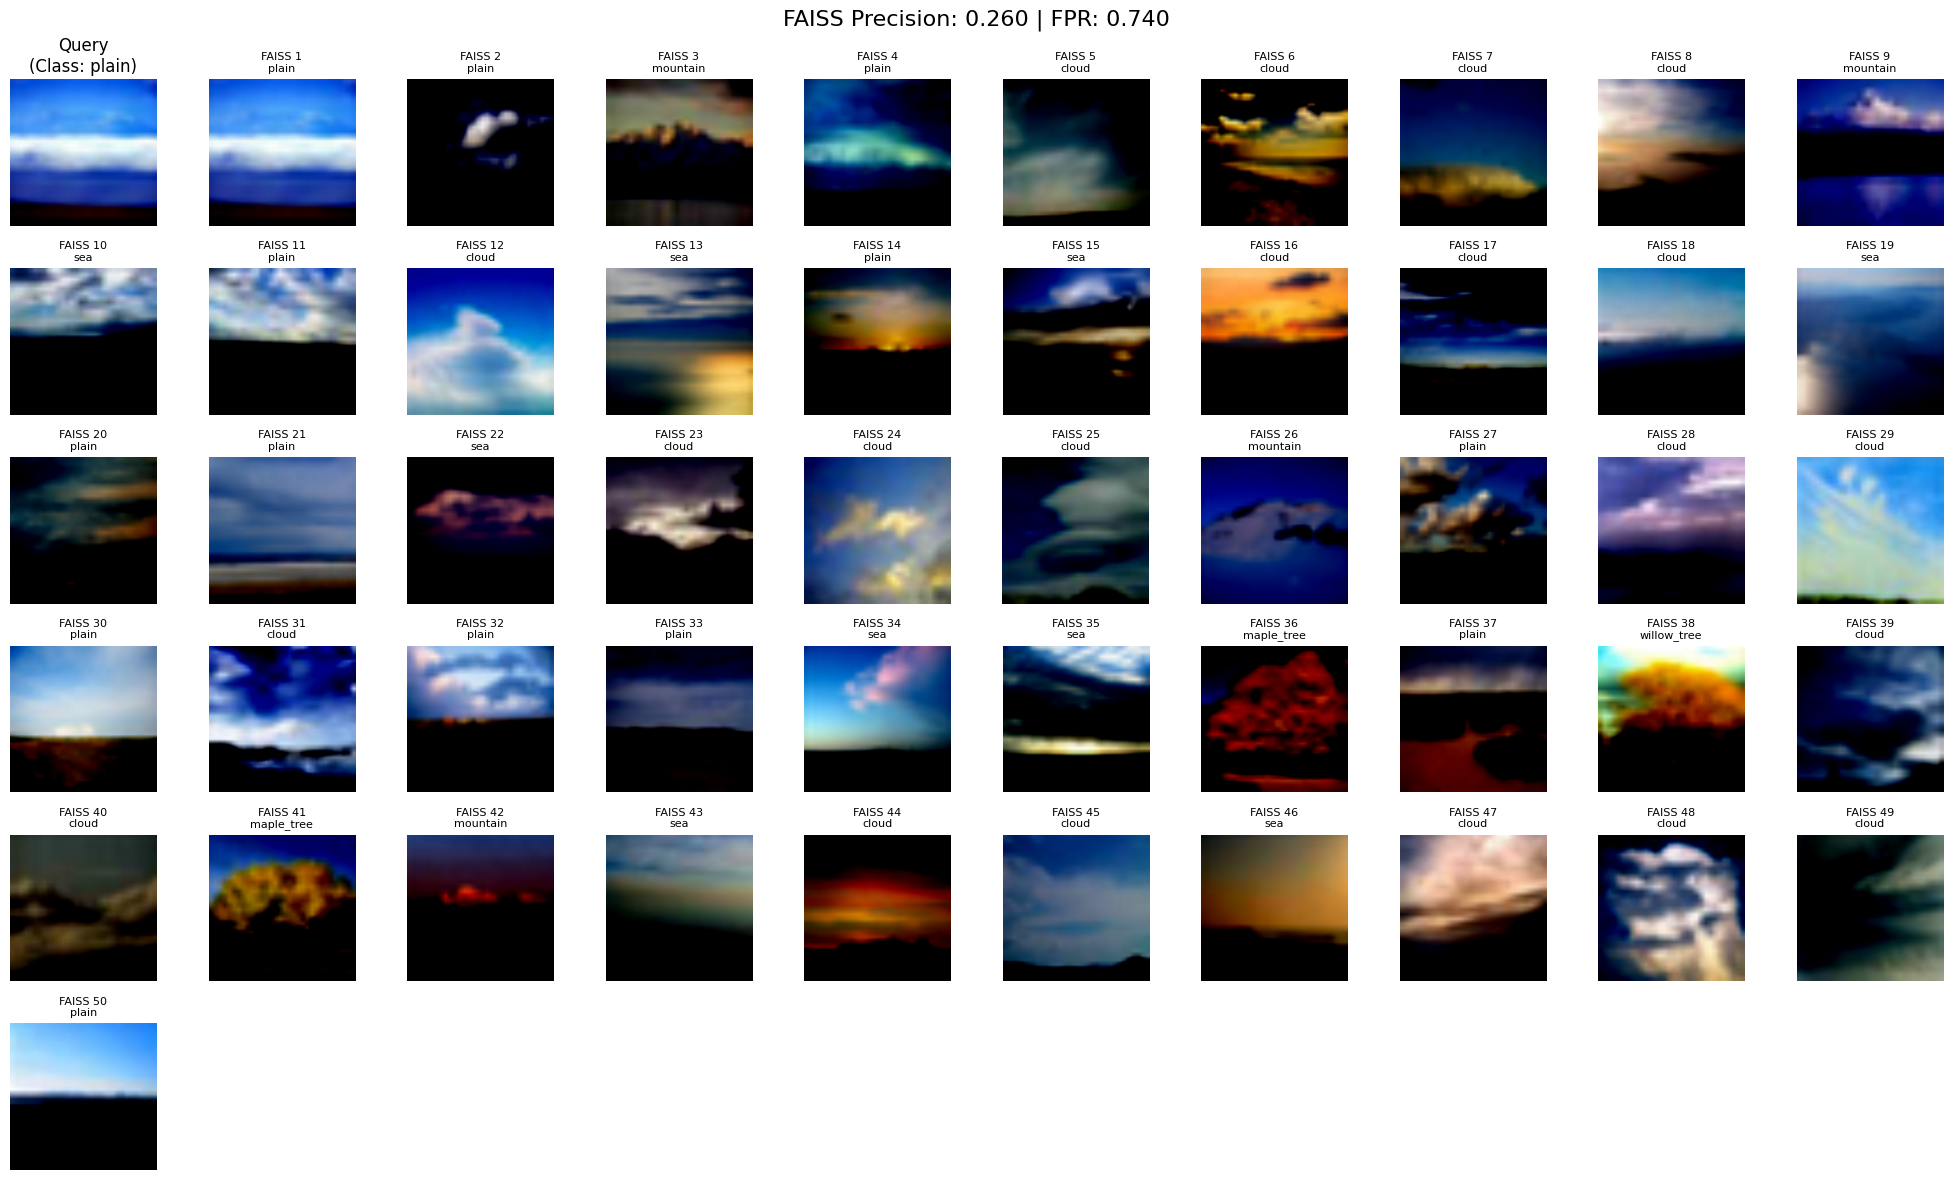


Query 2 (Index: 10, Label: keyboard):
Top-10: Precision = 1.000, FPR = 0.000
Top-20: Precision = 1.000, FPR = 0.000
Top-30: Precision = 1.000, FPR = 0.000
Top-40: Precision = 1.000, FPR = 0.000
Top-50: Precision = 1.000, FPR = 0.000


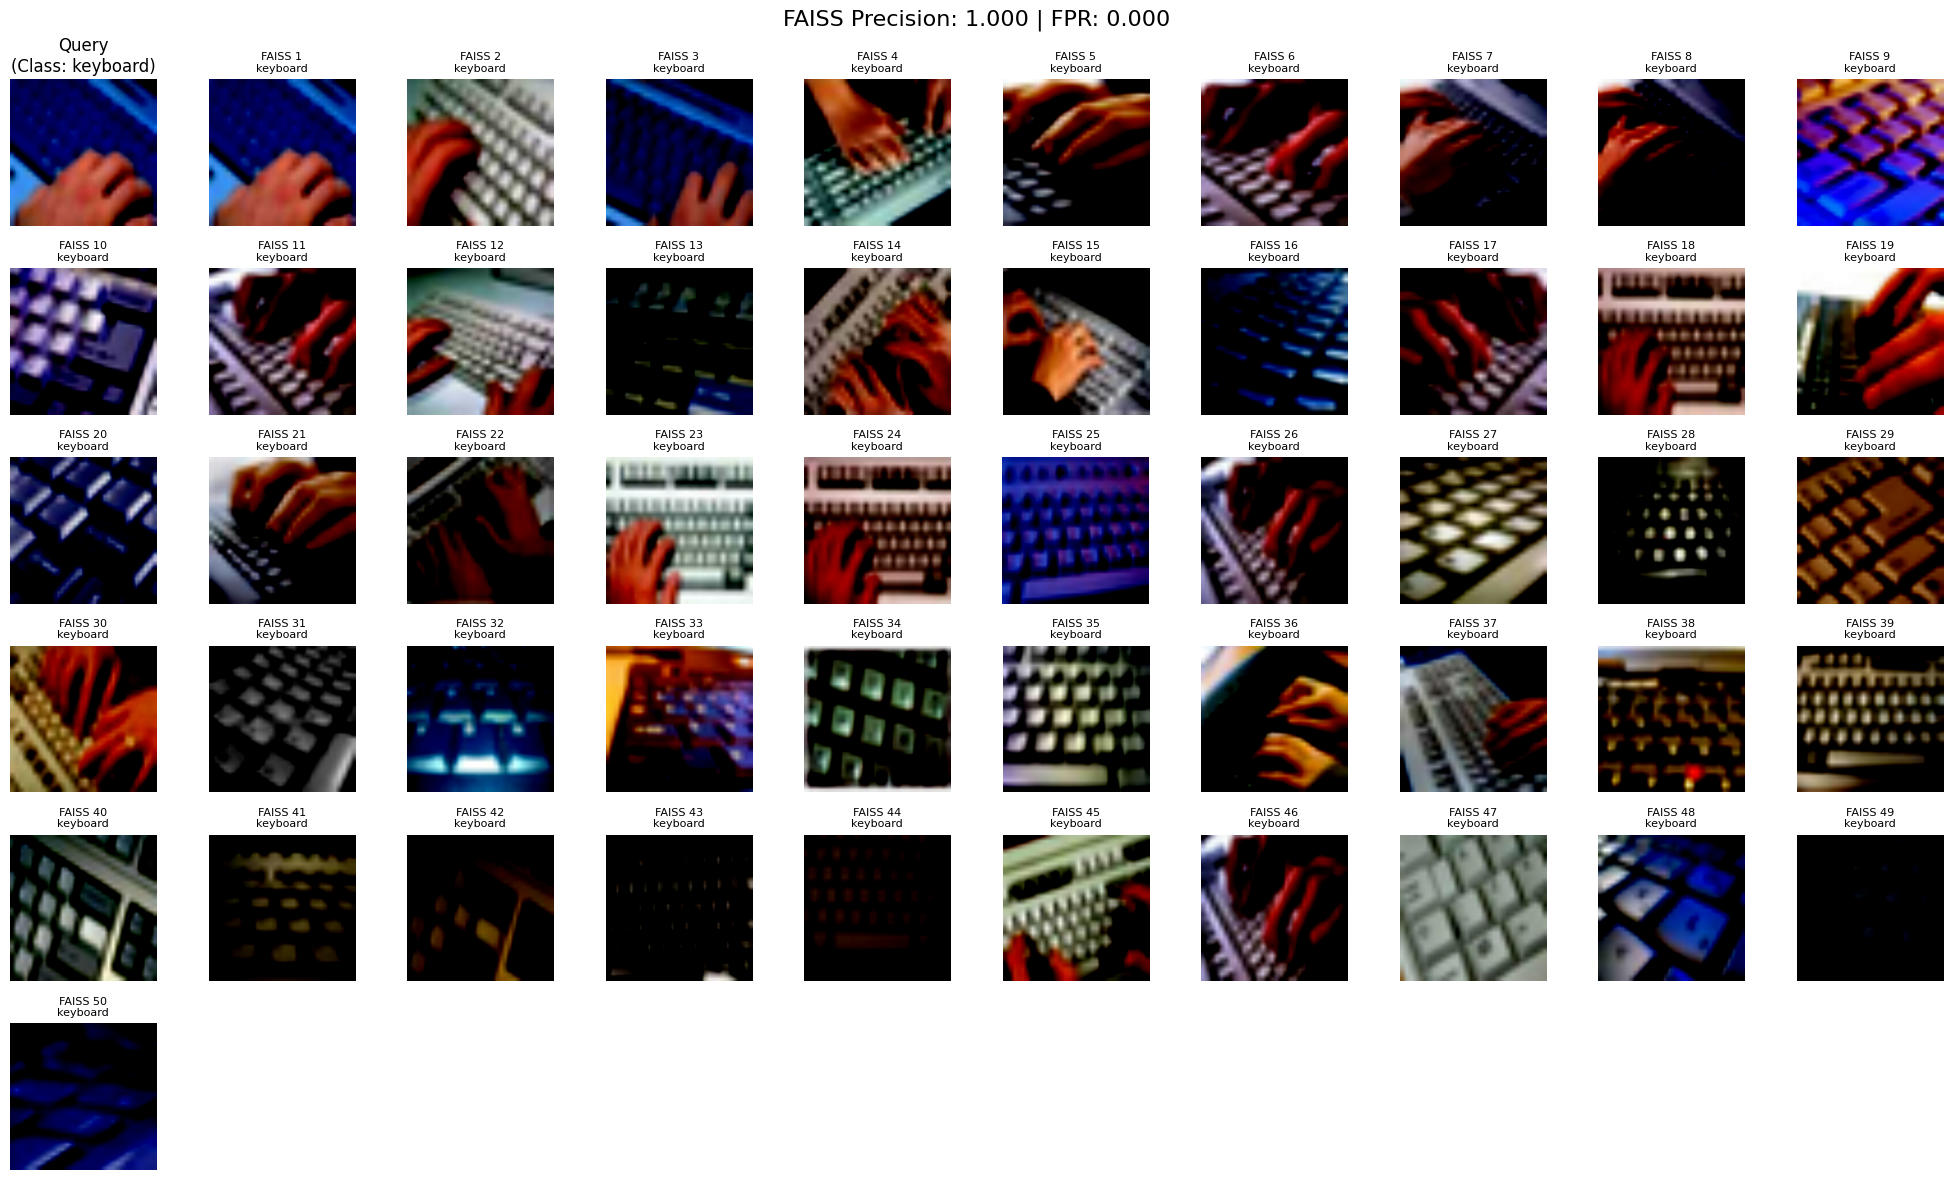


Query 3 (Index: 3330, Label: tractor):
Top-10: Precision = 0.100, FPR = 0.900
Top-20: Precision = 0.100, FPR = 0.900
Top-30: Precision = 0.067, FPR = 0.933
Top-40: Precision = 0.075, FPR = 0.925
Top-50: Precision = 0.060, FPR = 0.940


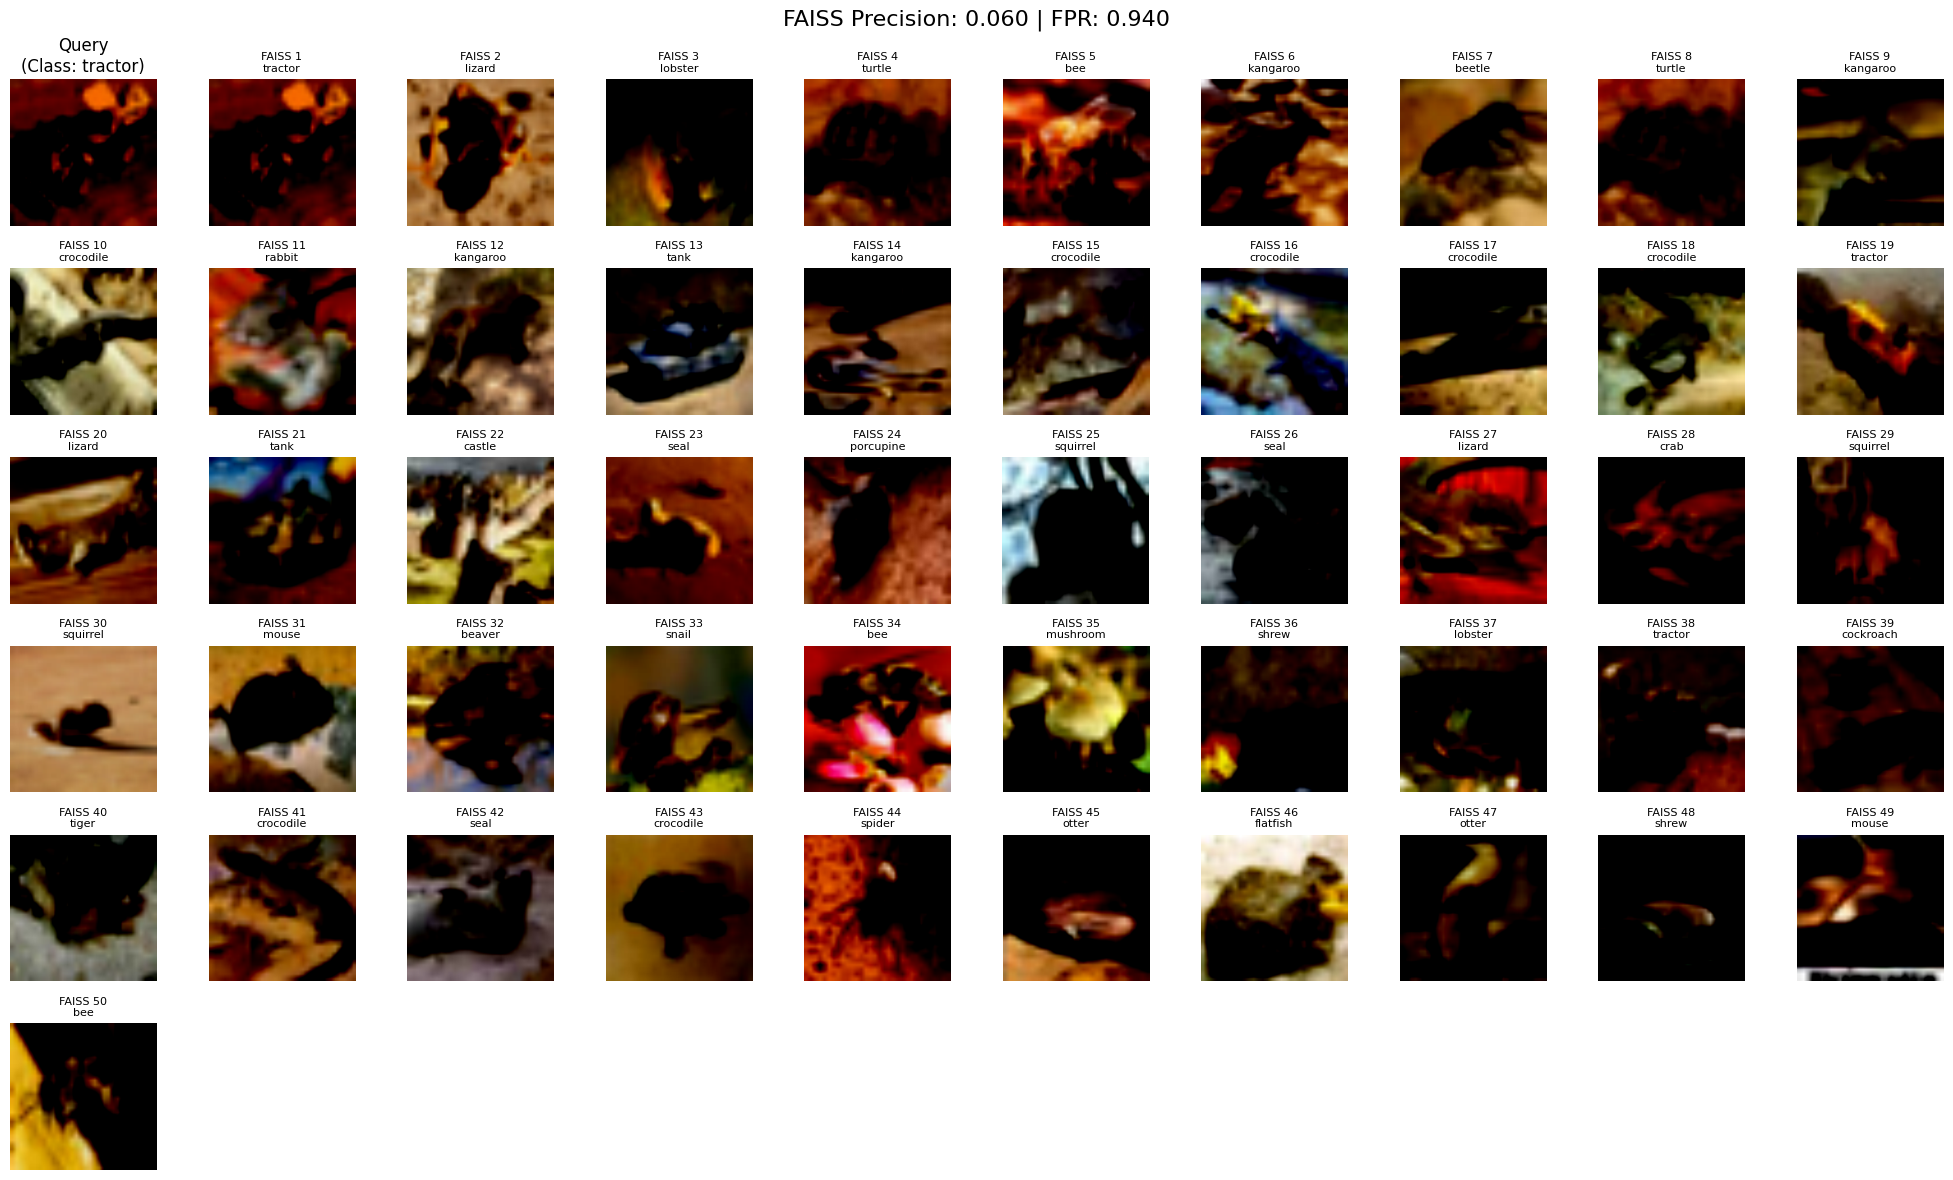


Query 4 (Index: 1024, Label: hamster):
Top-10: Precision = 0.200, FPR = 0.800
Top-20: Precision = 0.200, FPR = 0.800
Top-30: Precision = 0.133, FPR = 0.867
Top-40: Precision = 0.125, FPR = 0.875
Top-50: Precision = 0.100, FPR = 0.900


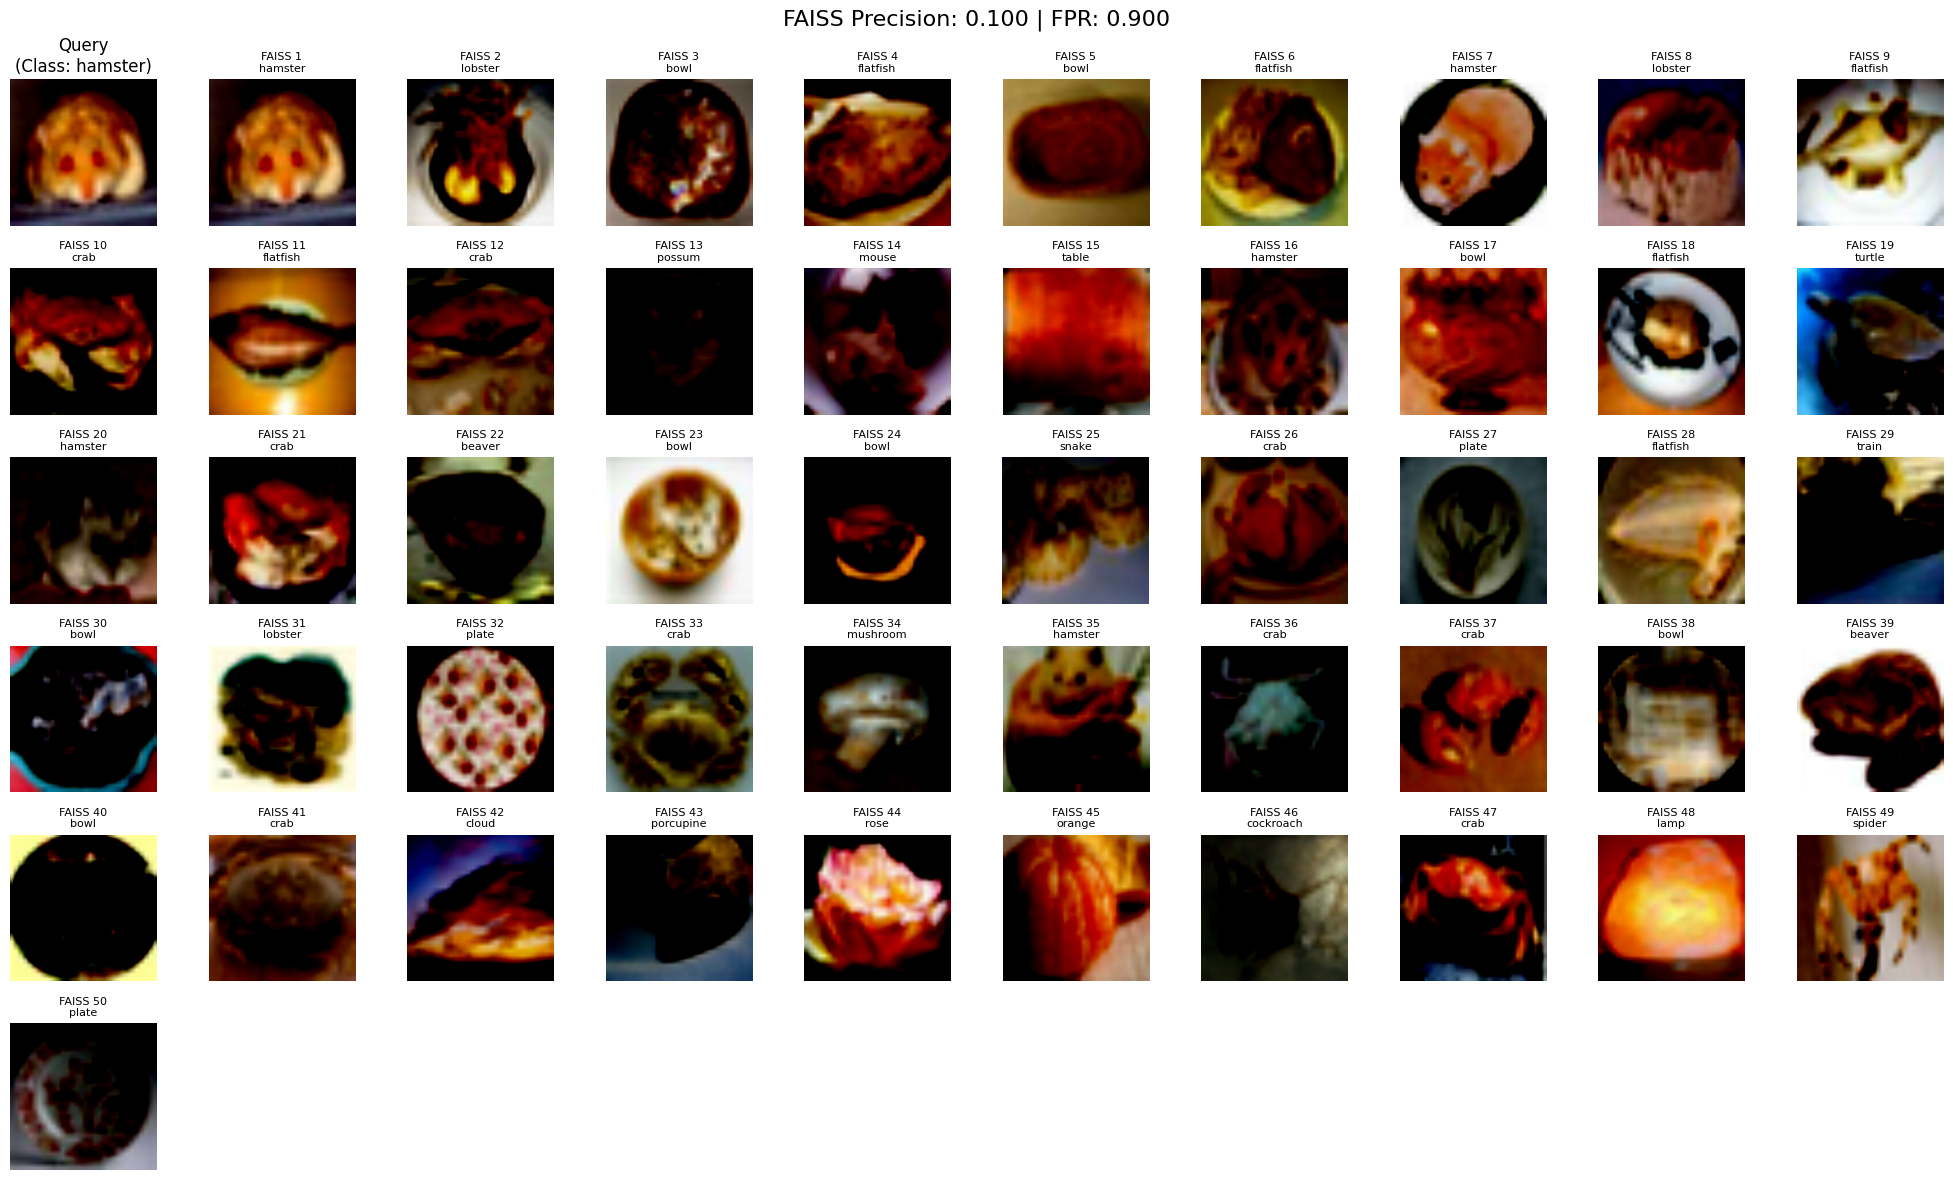


Query 5 (Index: 5789, Label: castle):
Top-10: Precision = 0.700, FPR = 0.300
Top-20: Precision = 0.750, FPR = 0.250
Top-30: Precision = 0.800, FPR = 0.200
Top-40: Precision = 0.800, FPR = 0.200
Top-50: Precision = 0.780, FPR = 0.220


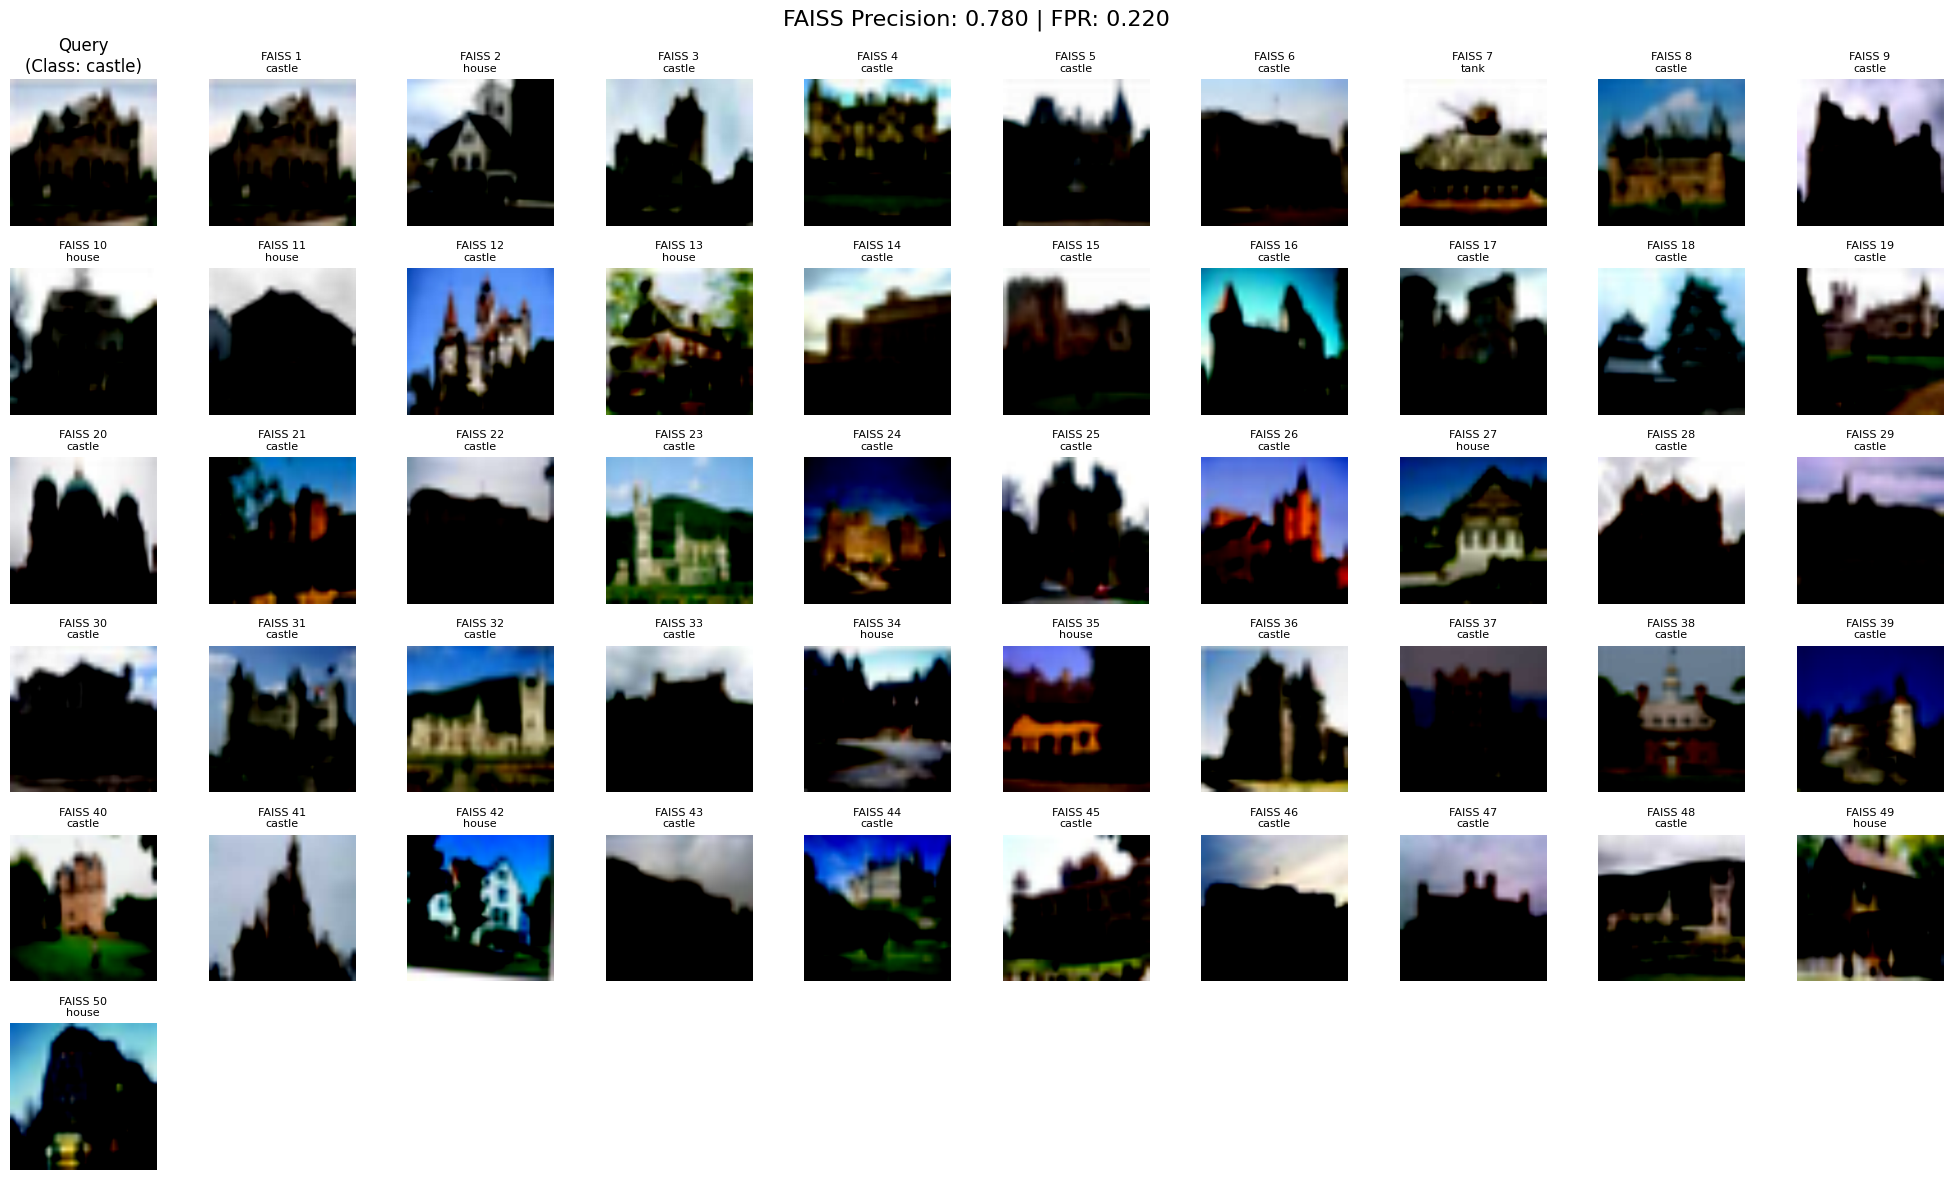

In [20]:
# Main execution
if __name__ == "__main__":
    dataset, dataloader = load_cifar100()
    label_names = dataset.classes
    labels = np.array(dataset.targets)

    embeddings = get_embeddings(dataloader)
    embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)
    faiss_index = build_faiss_index(embeddings)

    original_dataset = datasets.CIFAR100(root="./data", train=True, download=False, transform=transform)
    query_indices = [300, 10, 3330, 1024, 5789]
    ks = [10, 20, 30, 40, 50]

    for i, query_idx in enumerate(query_indices):
        query_img, query_label = original_dataset[query_idx]
        input_tensor = query_img.unsqueeze(0).to(device)

        query_embedding = extract_features(input_tensor).cpu().numpy()
        query_embedding = query_embedding / np.linalg.norm(query_embedding, axis=1, keepdims=True)

        faiss_results = faiss_search(faiss_index, query_embedding, k=100)

        print(f"\nQuery {i+1} (Index: {query_idx}, Label: {label_names[query_label]}):")
        for k in ks:
            precision_k, fpr_k = compute_metrics([faiss_results[:k]], [query_label], labels, k)
            print(f"Top-{k}: Precision = {precision_k:.3f}, FPR = {fpr_k:.3f}")

        show_results(query_img, faiss_results, original_dataset, query_label=query_label, faiss_precision=precision_k, faiss_fpr=fpr_k)


🔍 Processing custom image: /content/istockphoto-94323862-612x612 (1).jpg


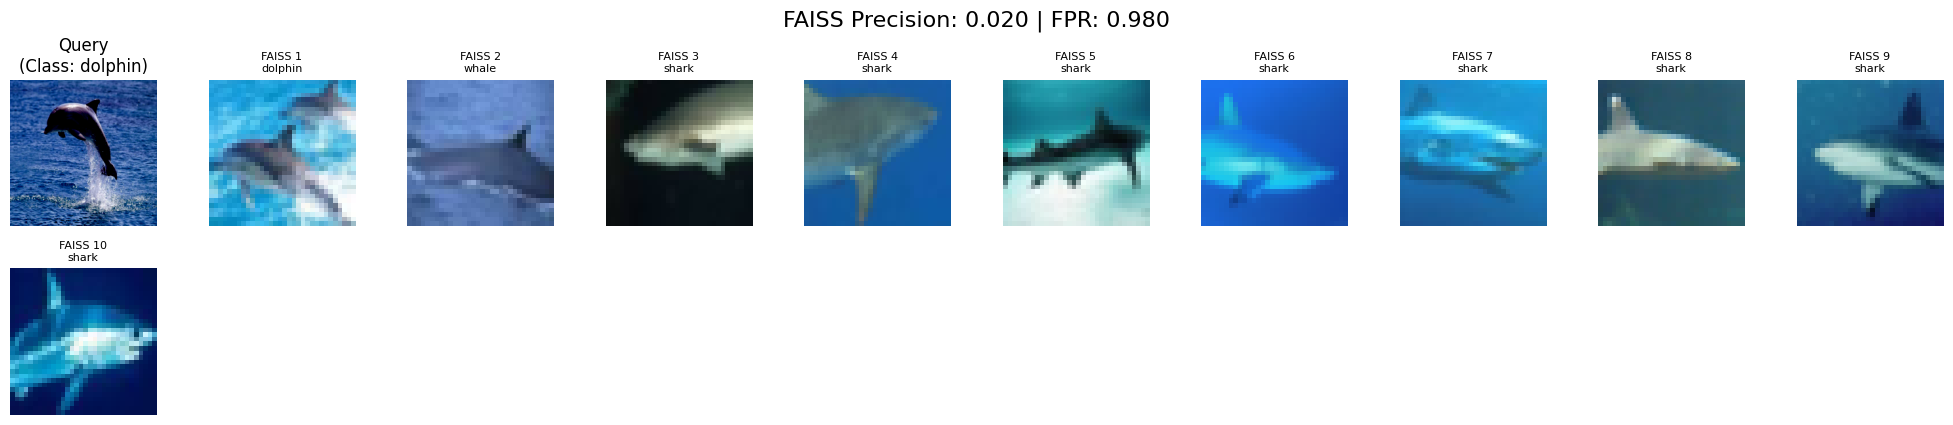


🔍 Processing custom image: /content/images (2).jpg


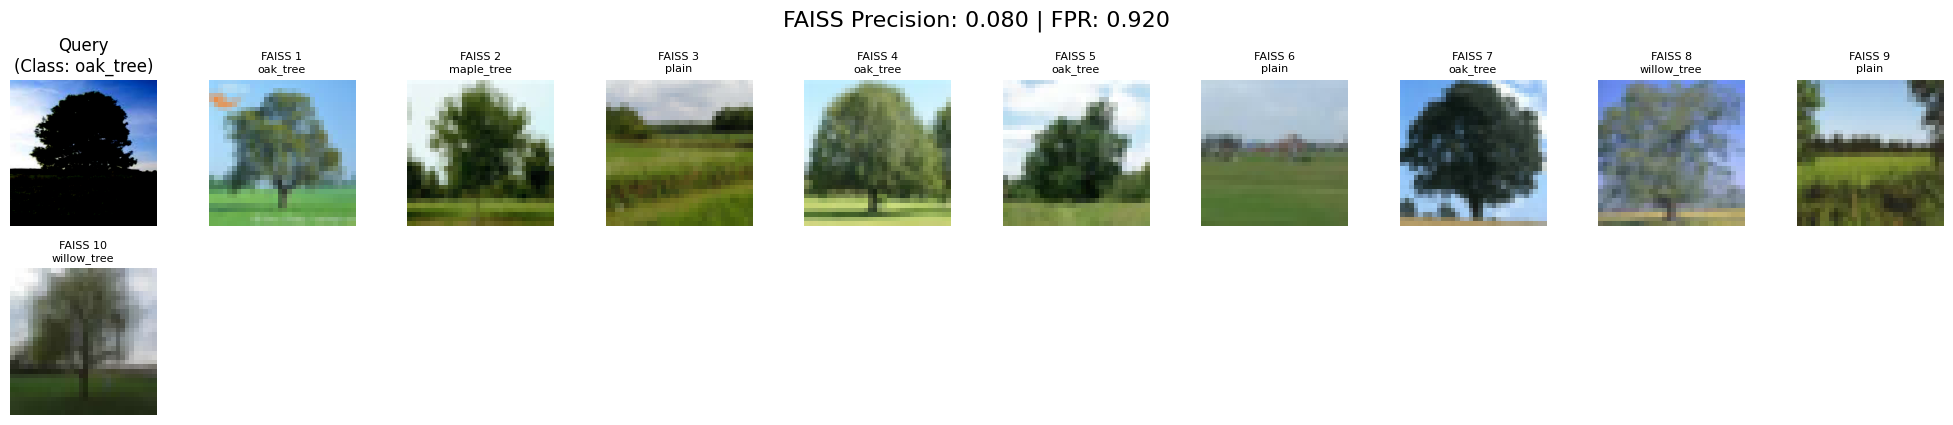


🔍 Processing custom image: /content/images (3).jpg


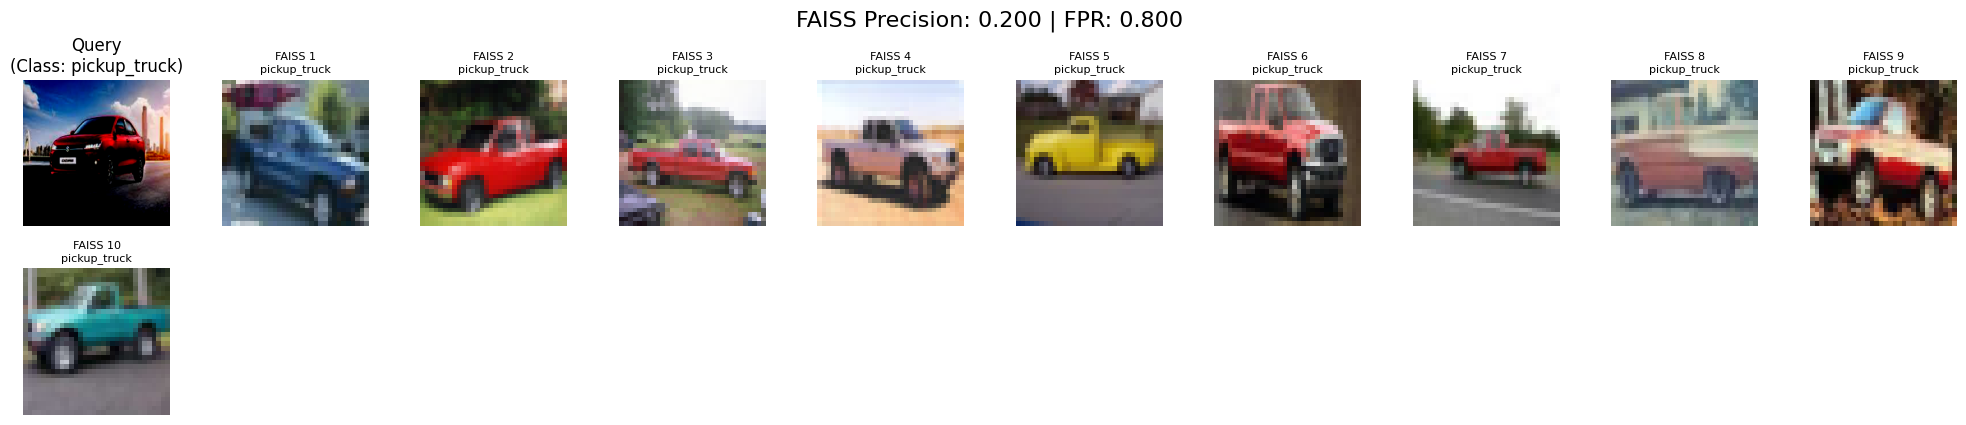

In [21]:
from PIL import Image

# Load original dataset (un-normalized) for visualization
original_dataset = datasets.CIFAR100(root="./data", train=True, download=False, transform=transforms.ToTensor())

# List of custom image paths
custom_image_paths = [
    "/content/istockphoto-94323862-612x612 (1).jpg",
    "/content/images (2).jpg",
    "/content/images (3).jpg"
]

all_query_embeddings = []
all_faiss_results = []

for i, path in enumerate(custom_image_paths):
    print(f"\n🔍 Processing custom image: {path}")
    img = Image.open(path).convert("RGB")
    query_img = transform(img)
    input_tensor = query_img.unsqueeze(0).to(device)

    # Extract embedding using RegNetX
    with torch.no_grad():
        query_feature = model(input_tensor)[-1]
        query_feature = torch.nn.functional.adaptive_avg_pool2d(query_feature, 1).squeeze(-1).squeeze(-1)
        query_embedding = query_feature.cpu().numpy()
        query_embedding = query_embedding / np.linalg.norm(query_embedding, axis=1, keepdims=True)

    # Search using FAISS
    faiss_results = faiss_search(faiss_index, query_embedding, k=10)

    all_query_embeddings.append(query_embedding[0])
    all_faiss_results.append(faiss_results)

    predicted_label = labels[faiss_results[0]]
    query_label = predicted_label  # Assuming label of nearest match as predicted

    precision, fpr = compute_metrics([faiss_results], [query_label], labels)

    show_results(query_img, faiss_results, original_dataset,
                 query_label=query_label, faiss_precision=precision, faiss_fpr=fpr)
